# Covid-19: From model prediction to model predictive control

## A tryout notebook for the MPC algorithm

*Code by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens and prof. Jan baetens of the KERMIT research unit.*

Copyright (c) 2021 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from covid19model.models import models
from covid19model.data import mobility, sciensano, model_parameters

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
###############
## Load data ##
###############

# Time-integrated contact matrices
initN, Nc_all = model_parameters.get_integrated_willem2012_interaction_matrices()
levels = initN.size
# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False)
# Sciensano public data
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)

## 1. Setup a simple SEIQRD model

In [3]:
from covid19model.models.base import BaseModel

class deterministic_SEIaIhQRD(BaseModel):

    # state variables and parameters
    state_names = ['S', 'E', 'Ia', 'Q', 'Im', 'Ih', 'R', 'D', 'H_in', 'H_rec', 'D_new', 'Im_rec']
    parameter_names = ['beta', 'sigma', 'gamma', 'a', 'h', 'IFR', 'psi']
    parameters_stratified_names = []
    stratification = ['Nc']

    @staticmethod
    def integrate(t, S, E, Ia, Q, Im, Ih, R, D, H_in, H_rec, D_new, Im_rec, beta, sigma, gamma, a, h, IFR, psi, Nc):
        
        d_hosp = 6.5
        
        # calculate total population
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~
        T = S + E + Ia + Im + Ih + R 

        # Adjust IFR if H_tot > 8000
        # ~~~~~~~~~~~~~~~~~~~~~~~~
        
        if Ih > 8000:
            IFR = IFR*2
            
        # Make sure number of tests cannot surpass number of asymptomatic individuals
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        if Ia + a*(1/sigma)*E - (1/gamma)*Ia <= psi:
            psi = Ia + a*(1/sigma)*E - (1/gamma)*Ia
        
        # Compute infection pressure (IP) of both variants
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        IP = beta*np.matmul(Nc,(Ia/T))

        # Compute the  rates of change in every population compartment
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        dS = - IP*S
        dE  = IP*S - (1/sigma)*E 
        dIa = a*(1/sigma)*E - (1/gamma)*Ia - psi
        dQ = psi - (1/gamma)*Q
        dIm = (1-a)*(1/sigma)*E - (1-h)*(1/gamma)*Im - h*(1/gamma)*Im
        dIh = h*(1/gamma)*Im - (1/(gamma+d_hosp))*Ih 
        dR = (1/gamma)*Ia + (1/gamma)*Q + (1-h)*(1/gamma)*Im + (1-IFR)*(1/(gamma+d_hosp))*Ih
        dD = IFR*(1/(gamma+d_hosp))*Ih

        dD_new = IFR*(1/(gamma+d_hosp))*Ih - D_new
        dH_in = h*(1/gamma)*Im - H_in
        dH_rec = (1-IFR)*(1/(gamma+d_hosp))*Ih  - H_rec
        dIm_rec = (1-h)*(1/gamma)*Im - Im_rec
        
        return dS, dE, dIa, dQ, dIm, dIh, dR, dD, dH_in, dH_rec, dD_new, dIm_rec

In [4]:
############################
## Define a draw function ##
############################

def draw_fcn(param_dict,samples_dict):
    return param_dict

In [5]:
###############################################
## Define new sort of social policy function ##
###############################################

from covid19model.models.time_dependant_parameter_fncs import ramp_fun
def compliance_func(t, states, param, l, effectivity):
    
    # Convert tau and l to dates
    l_days = pd.Timedelta(l, unit='D')
    # Define start of measures
    start_measures = pd.to_datetime('2020-03-15')
    # List of transitioning dates
    change_days = [start_measures,
                   start_measures + l_days]
    # List of transitioning values
    change_values = [param,
                     ramp_fun(param, effectivity*param, t, start_measures, l),
                     param * effectivity]
    # Return appropriate policy
    try:
        return change_values[[index for index,value in enumerate(change_days) if value > t][0]]
    except:
        return change_values[-1]

In [6]:
######################
## Initialize model ##
######################

# Define parameters
warmup = 40
l = 10
effectivity = 0.11
a = 0.57
h = 0.06
IFR = 0.214
Nc = np.ones(1)*sum(np.mean(Nc_all['total'],axis=0))
params = {'beta': 0.053, 'sigma': 3, 'gamma': 7, 'a': a, 'h': h, 'IFR': IFR, 'Nc': Nc,
          'l': l, 'effectivity': effectivity, 'psi': 0}
# Define initial states
initial_states = {"S": np.ones(1)*sum(initN), "E": np.ones(1)}
# Initialize model (SDEs are discrete time models and require the discrete=True flag upon initialization)
model = deterministic_SEIaIhQRD(initial_states, params, time_dependent_parameters={'Nc': compliance_func})

In [7]:
########################
## Perform simulation ##
########################

start_sim = '2020-03-15'
end_sim = '2020-07-15'
out = model.sim(end_sim,start_date=start_sim,warmup=warmup)

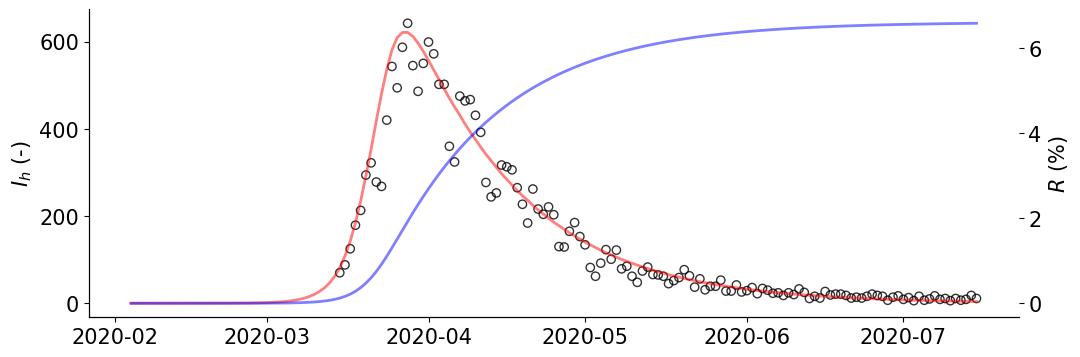

In [8]:
#######################
## Visualize results ##
#######################

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(out['time'],out['H_in'].sum(dim='Nc'), color='red', alpha = 0.5, linewidth = 2)
ax.scatter(df_sciensano[start_sim:end_sim].index,df_sciensano['H_in'][start_sim:end_sim],color='black',alpha=0.8,linestyle='None',facecolors='none')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.set_ylabel('$I_h$ (-)')
ax.grid(False)


ax2=ax.twinx()
ax2.plot(out['time'], out['R'].sum(dim='Nc')/sum(initN)*100, color='blue', alpha = 0.5, linewidth = 2)
ax2.set_ylabel('$R$ (%)')
ax2.grid(False)

plt.show()
plt.close()

## 2. Test some of the individual MPC functions

In [9]:
from covid19model.models.MPC import MPC

In [10]:
values_Nc = list(np.linspace(Nc*effectivity,Nc*effectivity*4,4))

daily_GDP = 1460e6

control_handles_dict = {'Nc': {
                                'continuous' : False,
                                'bounds_values' : values_Nc,
                                'costs' : list(daily_GDP*(np.linspace(0.3, 0, 4))),
                                }
                       }

In [11]:
controller = MPC(model, control_handles_dict)

In [12]:
values = [values_Nc[2],
          values_Nc[0],
          values_Nc[1],
          values_Nc[1],
          values_Nc[1],
          values_Nc[0],
          values_Nc[1]]
L = 14

### Tryout  `construct_horizon` TDPF

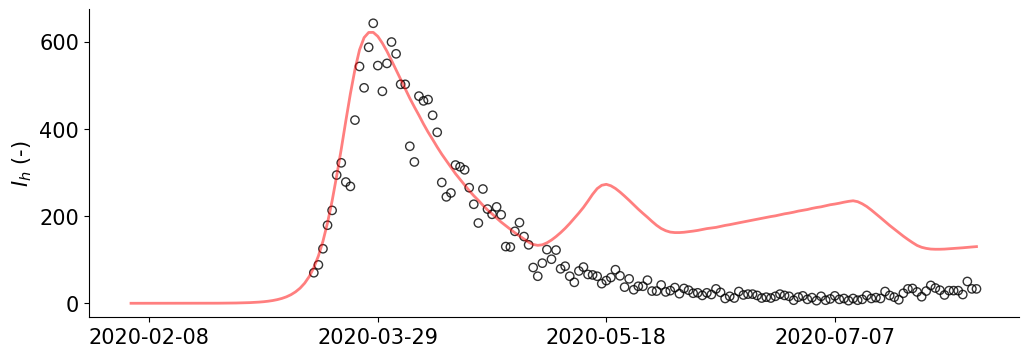

In [13]:
###############################
## Construct policy function ##
###############################

tryout_function = controller.construct_horizon(values, L, 'Nc', pd.to_datetime('2020-05-01'))
t = pd.Timestamp('2020-03-30')

############################
## Change policy function ##
############################

model.time_dependent_parameters.update({'Nc': tryout_function})

########################
## Perform simulation ##
########################

start_sim = '2020-03-15'
start_controller = '2020-05-01'
end_sim = pd.to_datetime(start_controller) + pd.Timedelta(days=len(values)*L)
out = model.sim(end_sim,start_date=start_sim,warmup=warmup)

#######################
## Visualize results ##
#######################

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(out['time'],out['H_in'].sum(dim='Nc'), color='red', alpha = 0.5, linewidth = 2)
ax.scatter(df_sciensano[start_sim:end_sim].index,df_sciensano['H_in'][start_sim:end_sim],color='black',alpha=0.8,linestyle='None',facecolors='none')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.set_ylabel('$I_h$ (-)')
ax.grid(False)
plt.show()
plt.close()

### Tryout `cost_economic`

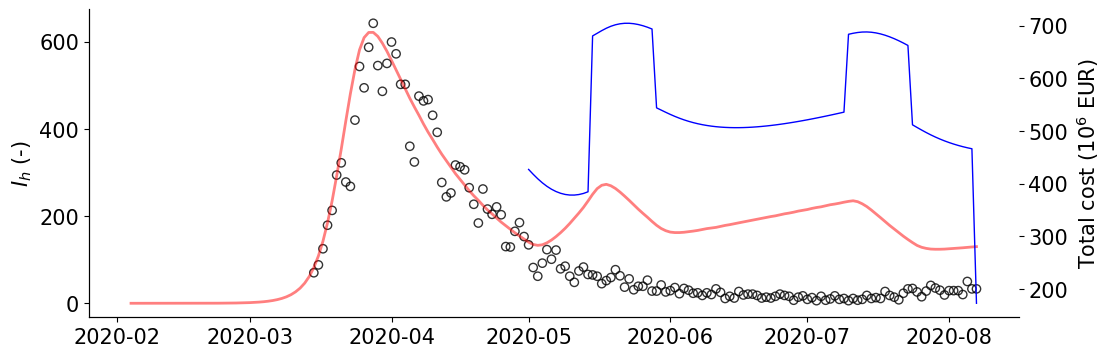

In [14]:
cost_lst = controller.cost_economic(out, {'Nc': values}, pd.to_datetime(start_controller), L, {'Ih': 8*50000*IFR} )/1e6

#######################
## Visualize results ##
#######################

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(out['time'],out['H_in'].sum(dim='Nc'), color='red', alpha = 0.5, linewidth = 2)
ax.scatter(df_sciensano[start_sim:end_sim].index,df_sciensano['H_in'][start_sim:end_sim],color='black',alpha=0.8,linestyle='None',facecolors='none')
ax.set_ylabel('$I_h$ (-)')
ax.grid(False)

ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

ax2=ax.twinx()
ax2.plot(pd.date_range(start=start_controller, periods=len(cost_lst)), cost_lst, color='blue', linewidth=1)    
ax2.grid(False)
ax2.set_ylabel('Total cost ($10^6$ EUR)')
plt.show()
plt.close()

### Tryout `cost_setpoint`

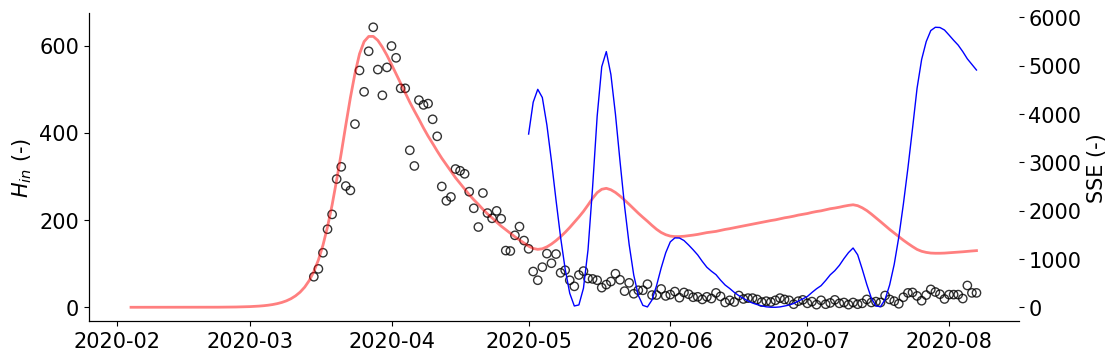

In [15]:
cost_lst = controller.cost_setpoint(out, {}, pd.to_datetime(start_controller), ['H_in'], [200], [1] )

#######################
## Visualize results ##
#######################

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(out['time'],out['H_in'].sum(dim='Nc'), color='red', alpha = 0.5, linewidth = 2)
ax.scatter(df_sciensano[start_sim:end_sim].index,df_sciensano['H_in'][start_sim:end_sim],color='black',alpha=0.8,linestyle='None',facecolors='none')
ax.set_ylabel('$H_{in}$ (-)')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.grid(False)

ax2=ax.twinx()
ax2.plot(pd.date_range(start=start_controller, periods=len(cost_lst)), cost_lst, color='blue', linewidth=1)    
ax2.grid(False)
ax2.set_ylabel('SSE (-)')
plt.show()
plt.close()

## 3. Test with one discrete control handle, `Nc` and setpoint cost function

### 3.1 Example optimization with pso algorithm (not prefered)

In [16]:
##################
## MPC settings ##
##################

L = 14
N = 5
P = 6
t_start_controller = pd.Timestamp('2020-05-01')
t_start_simulation = pd.Timestamp('2020-03-15')
cost_function = controller.cost_setpoint
cost_function_args = [['Ih'], [100], [1]]
simulation_kwargs={'warmup': warmup}

##################
## Optimization ##
##################

maxiter = 2
popsize = 2
thetas, thetas_values, thetas_TDPF = controller.pso_optimize(L, N, P, t_start_controller, t_start_simulation, cost_function, maxiter, popsize, *cost_function_args, **simulation_kwargs)

No constraints given.
New best for swarm at iteration 1: [1.03373344 1.00240963 1.73415187 1.37500008 2.47559031] 973256179.0579829
Best after iteration 1: [1.03373344 1.00240963 1.73415187 1.37500008 2.47559031] 973256179.0579829
New best for swarm at iteration 2: [0.74195259 0.01346937 2.20234741 1.66044918 2.15676702] 255838035.33600718
Best after iteration 2: [0.74195259 0.01346937 2.20234741 1.66044918 2.15676702] 255838035.33600718
Stopping search: maximum iterations reached --> 2


### 3.2 Tryout with package benderopt (under construction)

In [17]:
from benderopt import minimize

N = 3

#######################
## Wrap run function ##
#######################

run_theta_wrapper = controller.run_theta_wrapper
run_args = [L, P, t_start_controller, t_start_simulation, cost_function, cost_function_args, simulation_kwargs]

def obj_fun(**x):
    print(x)
    return run_theta_wrapper(x, *run_args)

#######################################
## Define parameters to be optimized ##
#######################################

optimization_problem_parameters = [
    {
        "name": "x1",
        "category" : "categorical",
        "search_space" : {
            "values" : control_handles_dict['Nc']['bounds_values']
        }
    },
    {
        "name": "x2",
        "category" : "categorical",
        "search_space" : {
            "values" : control_handles_dict['Nc']['bounds_values']
        }
    },
    {
        "name": "x3",
        "category" : "categorical",
        "search_space" : {
            "values" : control_handles_dict['Nc']['bounds_values']
        }
    }
]

######################
## Run optimization ##
######################

best_sample = minimize(obj_fun, optimization_problem_parameters, number_of_evaluation=2)

{'x1': array([11.56434832]), 'x2': array([11.56434832]), 'x3': array([2.89108708])}


ValueError: cannot reshape array of size 1 into shape (1,3)

### 3.3 Example optimization with rbfopt package (prefered)

In [18]:
##################
## MPC settings ##
##################

L = 21
N = 8
P = 10
t_start_controller = pd.Timestamp('2020-05-01')
t_start_simulation = pd.Timestamp('2020-03-15')
cost_function = controller.cost_setpoint
cost_function_args = [['H_in'], [200], [1]]
simulation_kwargs={'warmup': warmup}

##################
## Optimization ##
##################

max_evals=5000
thetas, thetas_values, thetas_TDPF = controller.rbfopt_optimize(L, N, P, t_start_controller, t_start_simulation, cost_function, max_evals, *cost_function_args, **simulation_kwargs)
print(thetas)

  Iter  Cycle  Action             Objective value      Time      Gap
  ----  -----  ------             ---------------      ----      ---


KeyboardInterrupt: 

### 3.3 Visualize result

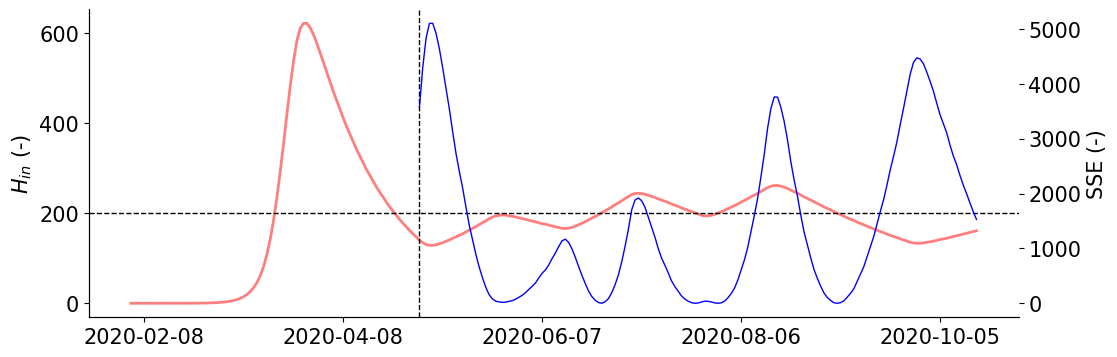

In [32]:
#########################
## Set estimated TDPFs ##
#########################

for ch,TDPF in thetas_TDPF.items():
    model.time_dependent_parameters.update({ch: TDPF})
    
########################
## Perform simulation ##
########################

start_sim = '2020-03-15'
start_controller = '2020-05-01'
end_sim = pd.to_datetime(start_controller) + pd.Timedelta(days=N*L)
out = model.sim(end_sim,start_date=start_sim,warmup=warmup)

###########################
## Compute cost function ##
###########################

cost_lst = controller.cost_setpoint(out, {}, t_start_controller, *cost_function_args)

#######################
## Visualize results ##
#######################

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(out['time'],out['H_in'].sum(dim='Nc'), color='red', alpha = 0.5, linewidth = 2)
ax.axhline(y=200, ls='--',color='black',linewidth=1)
ax.axvline(x=t_start_controller, ls='--',color='black',linewidth=1)
#ax.scatter(df_sciensano[start_sim:end_sim].index,df_sciensano['H_in'][start_sim:end_sim],color='black',alpha=0.8,linestyle='None',facecolors='none')
ax.set_ylabel('$H_{in}$ (-)')
ax.grid(False)

ax2=ax.twinx()
ax2.plot(pd.date_range(start=start_controller, periods=len(cost_lst)), cost_lst, color='blue', linewidth=1)    
ax2.grid(False)
ax2.set_ylabel('SSE (-)')

ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.show()
plt.close()

### 3.4 Variation of the policy length

In [ ]:
#[0. 0. 4. 0. 1. 0. 2. 1.] # L=14, N=8, P=10
#[0., 1., 1., 1., 0., 2., 0., 2.] # L=14, N=8, P=8

L = 14
N = 8
P = 8

N_lst = [8, 8, 8]
L_lst = [21, 14, 7]
# Setpoint 100
thetas_lst = [
    [1., 0., 1., 1., 1., 1., 0., 1.],
    [0., 1., 1., 1., 0., 2., 0., 2.],
    [0., 1., 1., 0., 2., 0., 0., 4.],
]

# Setpoint 200
#thetas_lst = [
#    #[2., 0., 0., 1., 2., 1., 0., 2.],
#    [1., 1., 1., 0., 2., 0., 2., 0.],
#    [2., 0., 1., 1., 1., 0., 2., 0.],
#    [2., 1., 0., 1., 1., 1., 1., 0.],
#]

legend_text = ['$L = 21$','$L = 14$','$L = 7$']

linestyles = ['-',':', '--']

fig,ax=plt.subplots(figsize=(12,4))

for idx,thetas in enumerate(thetas_lst):
    
    ######################################
    ## Retrieve the corresponding TDPFs ##
    ######################################

    # Control horizon dictionary
    thetas_values = controller.thetas_to_control_handles(thetas)
    # Conversion into prediction horizon dictionary
    #for key,value in thetas_values.items():
    #    value +=  value[-1] * (P-N) 
    # Conversion into prediction horizon TDPFs
    thetas_TDPF={}
    for ch,ph in thetas_values.items():
        thetas_TDPF.update({ch : controller.construct_horizon(ph, L_lst[idx], ch, t_start_controller)})
        
    #########################
    ## Set estimated TDPFs ##
    #########################

    for ch,TDPF in thetas_TDPF.items():
        model.time_dependent_parameters.update({ch: TDPF})

    ########################
    ## Perform simulation ##
    ########################

    start_sim = '2020-03-15'
    start_controller = '2020-05-01'
    end_sim = pd.to_datetime(start_controller) + pd.Timedelta(days=N_lst[idx]*L_lst[idx])
    out = model.sim(end_sim,start_date=start_sim,warmup=warmup)
    
    ###############
    ## Visualize ##
    ###############
    
    ax.plot(out['time'],out['H_in'].sum(dim='Nc'), color='black', alpha = 1, linewidth = 1.5, linestyle=linestyles[idx])

ax.axvline(x=t_start_controller, ls='--',color='black',linewidth=1)
ax.axhline(y=100,color='red',linewidth=1)
#ax.legend(legend_text, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13, title='$N = 8$, $P = 8$')
ax.set_ylabel('$H_{in}$ (-)')
ax.set_xlim(pd.to_datetime('2020-03-10'),None)
ax.grid(False)
plt.show()
plt.close()
fig.savefig('controller_setpoint_100.pdf', dpi=300, bbox_inches='tight')

### 3.5 Variation of the number of policies

In [28]:
values_Nc = list(np.linspace(Nc*effectivity,Nc*effectivity*4,6))

control_handles_dict = {'Nc': {
                                'continuous' : False,
                                'bounds_values' : values_Nc,
                                'costs' : list(daily_GDP*(np.linspace(0.3, 0, 6))),
                                }
                       }
controller.control_handles_dict = control_handles_dict

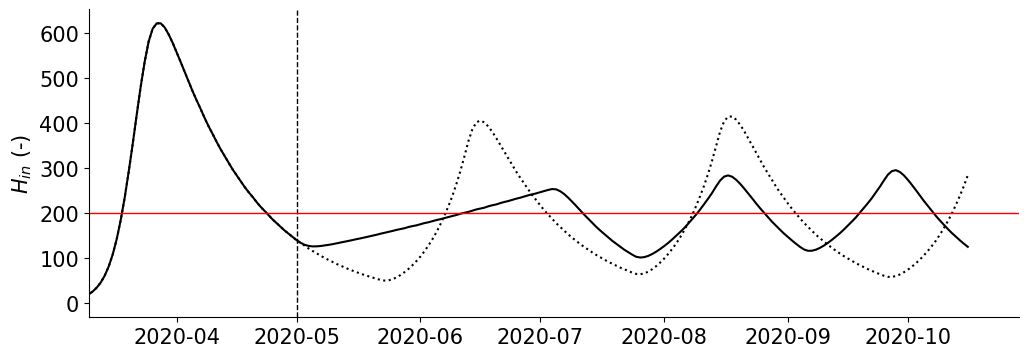

In [37]:
# Setpoint 200
thetas_lst = [
    #[2., 1., 2., 1., 2., 1., 1., 2.], # L = 21, N  = 8, P = 8, 6 levels
    [1., 1., 1., 0., 2., 0., 2., 0.], # L = 21, N  = 8, P = 8, 4 levels
    [0., 2., 0., 0., 2., 0., 0., 2.], # L = 21, N  = 8, P = 8, 2 levels
]

# Definition of N and L
N = 8
L = 21

# Number of values for Nc
Nc_no_values = [4,2]

# Plot styles
legend_text = ['$L = 21$','$L = 14$','$L = 7$']
linestyles = ['-',':', '--']

fig,ax=plt.subplots(figsize=(12,4))

for idx,thetas in enumerate(thetas_lst):

    # Adjust control handles dict
    control_handles_dict = {'Nc': {
                                'continuous' : False,
                                'bounds_values' : list(np.linspace(Nc*effectivity,Nc*effectivity*4,Nc_no_values[idx])),
                                'costs' : list(daily_GDP*(np.linspace(0.35, 0, Nc_no_values[idx]))),
                                }
                       }
    controller.control_handles_dict = control_handles_dict
    
    ######################################
    ## Retrieve the corresponding TDPFs ##
    ######################################

    # Control horizon dictionary
    thetas_values = controller.thetas_to_control_handles(thetas)
    # Conversion into prediction horizon dictionary
    #for key,value in thetas_values.items():
    #    value +=  value[-1] * (P-N) 
    # Conversion into prediction horizon TDPFs
    thetas_TDPF={}
    for ch,ph in thetas_values.items():
        thetas_TDPF.update({ch : controller.construct_horizon(ph, L, ch, t_start_controller)})
        
    #########################
    ## Set estimated TDPFs ##
    #########################

    for ch,TDPF in thetas_TDPF.items():
        model.time_dependent_parameters.update({ch: TDPF})

    ########################
    ## Perform simulation ##
    ########################

    start_sim = '2020-03-15'
    start_controller = '2020-05-01'
    end_sim = pd.to_datetime(start_controller) + pd.Timedelta(days=N*L)
    out = model.sim(end_sim,start_date=start_sim,warmup=warmup)
    
    ###############
    ## Visualize ##
    ###############
    
    ax.plot(out['time'],out['H_in'].sum(dim='Nc'), color='black', alpha = 1, linewidth = 1.5, linestyle=linestyles[idx])

ax.axvline(x=t_start_controller, ls='--',color='black',linewidth=1)
ax.axhline(y=200,color='red',linewidth=1)
#ax.legend(legend_text, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13, title='$N = 8$, $P = 8$')
ax.set_ylabel('$H_{in}$ (-)')
ax.set_xlim(pd.to_datetime('2020-03-10'),None)
ax.grid(False)
plt.show()
plt.close()
fig.savefig('controller_setpoint_200_vary_policy.pdf', dpi=300, bbox_inches='tight')

## 4. Test with discrete control handle, `Nc` and economic cost function

In [19]:
control_handles_dict = {'Nc': {
                                'continuous' : False,
                                'bounds_values' : values_Nc,
                                'costs' : list(daily_GDP*(np.linspace(0.35, 0, 4))),
                                }
                       }
controller.control_handles_dict = control_handles_dict

In [20]:
##################
## MPC settings ##
##################

L = 14
N = 8
P = 16
t_start_controller = pd.Timestamp('2020-05-01')
t_start_simulation = pd.Timestamp('2020-03-15')
cost_function = controller.cost_economic

###################
## Cost settings ##
###################

cost_QALY_yr = 85000
cost_QALY_day = cost_QALY_yr/365

# chronic effects
cost_long_covid = 0.10*(0.7*0.25)*12*cost_QALY_yr # 10% of recovered, disutility 0.25 (disappears in time), 12 QALYs remaining
cost_handicap = 0.50*0.25*5*cost_QALY_yr # 50% of recovered in hospital, permanent disutility of 0.25, 5 QALYS remaining
# acute effects
cost_death = 5*cost_QALY_yr
cost_symptoms = 0.25*cost_QALY_day # disutility * QALY loss/sick day
cost_absenteeism = daily_GDP/3.5e6 # GDP scaled with fraction sick workers
cost_hospitalization = 0.5*(1/365)*cost_QALY_day # disutility * QALY loss/sick day

cost_function_args = [L, {'D_new': cost_death,
                          # long-COVID
                          'Im_rec' : cost_long_covid,   
                           # handicap after hospitalization
                          'H_rec' : cost_handicap,
                           # absenteeism + symptoms + long-COVID
                          'Im': cost_absenteeism + cost_symptoms,
                           # hospitalisation
                          'Ih': cost_hospitalization}]

simulation_kwargs={'warmup': warmup}

##################
## Optimization ##
##################

max_evals=300
thetas, thetas_values, thetas_TDPF = controller.rbfopt_optimize(L, N, P, t_start_controller, t_start_simulation, cost_function, max_evals, *cost_function_args, **simulation_kwargs)
print(thetas)

  Iter  Cycle  Action             Objective value      Time      Gap
  ----  -----  ------             ---------------      ----      ---


KeyboardInterrupt: 

In [ ]:
#########################
## Set estimated TDPFs ##
#########################

for ch,TDPF in thetas_TDPF.items():
    model.time_dependent_parameters.update({ch: TDPF})
    
########################
## Perform simulation ##
########################

start_sim = '2020-03-15'
start_controller = '2020-05-01'
end_sim = pd.to_datetime(start_controller) + pd.Timedelta(days=N*L)
out = model.sim(end_sim,start_date=start_sim,warmup=warmup)

###########################
## Compute cost function ##
###########################

cost_lst = controller.cost_economic(out, thetas_values, t_start_controller, *cost_function_args)

#######################
## Visualize results ##
#######################

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(out['time'],out['H_in'].sum(dim='Nc'), color='red', alpha = 0.5, linewidth = 2)
#ax.scatter(df_sciensano[start_sim:end_sim].index,df_sciensano['H_in'][start_sim:end_sim],color='black',alpha=0.8,linestyle='None',facecolors='none')
ax.set_ylabel('$H_{in}$ (-)')
ax.grid(False)

ax2=ax.twinx()
ax2.plot(pd.date_range(start=start_controller, periods=len(cost_lst)), cost_lst, color='blue', linewidth=1)    
ax2.grid(False)
ax2.set_ylabel('Cost (EUR)')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.show()
plt.close()

### 4.1 Summary figure

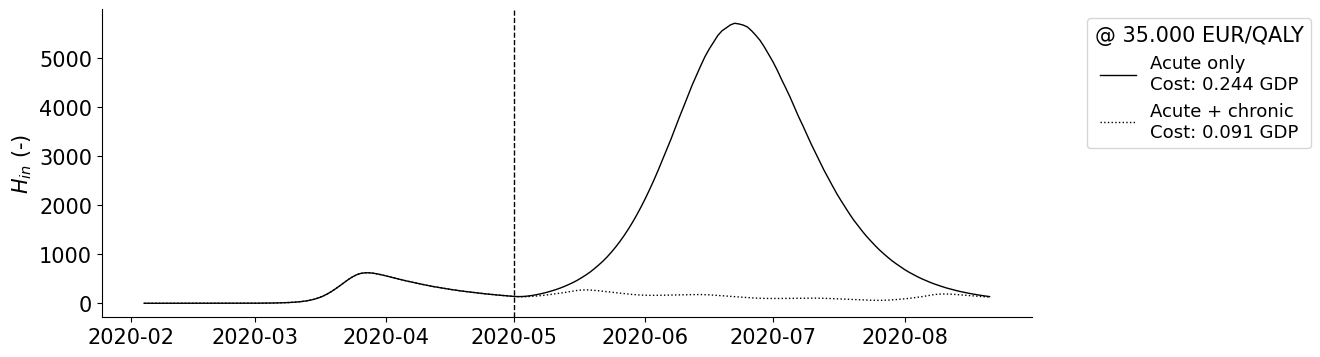

In [22]:
thetas_lst = [
    [3., 3., 4., 3., 3., 3., 4., 3.],
    [2., 0., 1., 0., 1., 0., 3., 0.],
]

cost_lst = [30215196411, 42552282606]

legend_text = ['Acute only', 'Acute + chronic']
L = 14
N = 8
P = 14

linestyles = ['-',':']

fig,ax=plt.subplots(figsize=(12,4))

for idx,thetas in enumerate(thetas_lst):
    
    ######################################
    ## Retrieve the corresponding TDPFs ##
    ######################################

    # Control horizon dictionary
    thetas_values = controller.thetas_to_control_handles(thetas)
    # Conversion into prediction horizon dictionary
    for key,value in thetas_values.items():
        value +=  value[-1] * (P-N) 
    # Conversion into prediction horizon TDPFs
    thetas_TDPF={}
    for ch,ph in thetas_values.items():
        thetas_TDPF.update({ch : controller.construct_horizon(ph, L, ch, t_start_controller)})
        
    #########################
    ## Set estimated TDPFs ##
    #########################

    for ch,TDPF in thetas_TDPF.items():
        model.time_dependent_parameters.update({ch: TDPF})

    ########################
    ## Perform simulation ##
    ########################

    start_sim = '2020-03-15'
    start_controller = '2020-05-01'
    end_sim = pd.to_datetime(start_controller) + pd.Timedelta(days=N*L)
    out = model.sim(end_sim,start_date=start_sim,warmup=warmup)

    ##################################################
    ## Compute cost function (with chronic effects) ##
    ##################################################

    # chronic effects
    cost_long_covid = 0.10*(0.7*0.25)*12*cost_QALY_yr # 10% of recovered, disutility 0.25 (disappears in time), 12 QALYs remaining
    cost_handicap = 0.50*0.25*5*cost_QALY_yr # 50% of recovered in hospital, permanent disutility of 0.25, 5 QALYS remaining
    # acute effects
    cost_death = 5*cost_QALY_yr
    cost_symptoms = 0.25*cost_QALY_day # disutility * QALY loss/sick day
    cost_absenteeism = daily_GDP/3.5e6 # GDP scaled with fraction sick workers
    cost_hospitalization = 0.5*(1/365)*cost_QALY_day # disutility * QALY loss/sick day

    cost_function_args = [L, {'D_new': cost_death,
                          # long-COVID
                          'Im_rec' : cost_long_covid,   
                           # handicap after hospitalization
                          'H_rec' : cost_handicap,
                           # absenteeism + symptoms + long-COVID
                          'Im': cost_absenteeism + cost_symptoms,
                           # hospitalisation
                          'Ih': cost_hospitalization}]

    cost_lst = controller.cost_economic(out, thetas_values, t_start_controller, *cost_function_args)

    cost_str = "{:.3f}".format(sum(cost_lst)/(daily_GDP*365))
    legend_text[idx] += '\nCost: ' + str(cost_str) + ' GDP'
    
    ###############
    ## Visualize ##
    ###############
    
    ax.plot(out['time'],out['H_in'].sum(dim='Nc'), color='black', alpha = 1, linewidth = 1, linestyle=linestyles[idx])

ax.axvline(x=t_start_controller, ls='--',color='black',linewidth=1)
ax.legend(legend_text, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13, title='@ 35.000 EUR/QALY')
ax.set_ylabel('$H_{in}$ (-)')
ax.grid(False)
plt.show()
plt.close()
fig.savefig('controller_economic_35000.pdf', dpi=300, bbox_inches='tight')

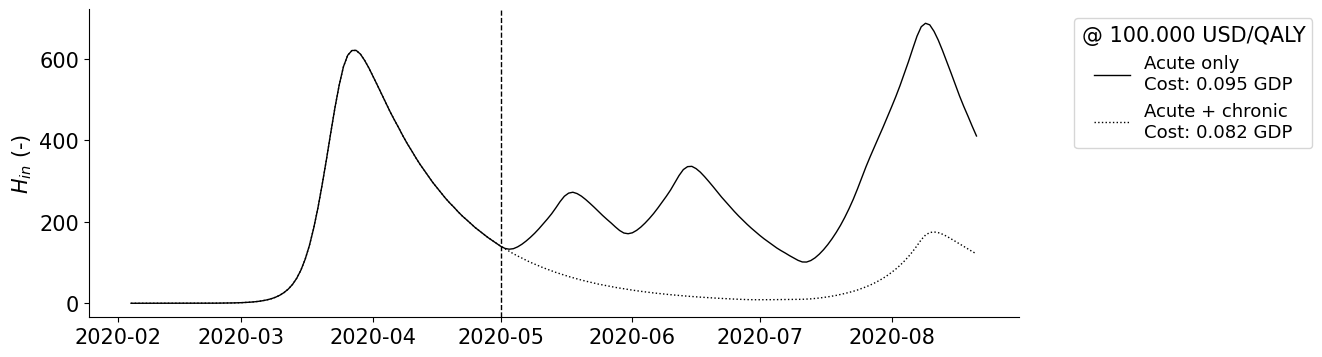

In [23]:
# [1., 1., 1., 0., 0., 2., 3., 0.] N=8, P=14
#[0., 0., 1., 0., 0., 3., 3., 0.] 

thetas_lst = [
    [2., 0., 2., 0., 0., 3., 2., 0.],
    [0., 0., 0., 0., 1., 3., 3., 0.],
]

legend_text = ['Acute only', 'Acute + chronic']
L = 14
N = 8
P = 16

linestyles = ['-', ':', '--']

fig,ax=plt.subplots(figsize=(12,4))

for idx,thetas in enumerate(thetas_lst):
    
    ######################################
    ## Retrieve the corresponding TDPFs ##
    ######################################

    # Control horizon dictionary
    thetas_values = controller.thetas_to_control_handles(thetas)
    # Conversion into prediction horizon dictionary
    for key,value in thetas_values.items():
        value +=  value[-1] * (P-N) 
    # Conversion into prediction horizon TDPFs
    thetas_TDPF={}
    for ch,ph in thetas_values.items():
        thetas_TDPF.update({ch : controller.construct_horizon(ph, L, ch, t_start_controller)})
        
    #########################
    ## Set estimated TDPFs ##
    #########################

    for ch,TDPF in thetas_TDPF.items():
        model.time_dependent_parameters.update({ch: TDPF})

    ########################
    ## Perform simulation ##
    ########################

    start_sim = '2020-03-15'
    start_controller = '2020-05-01'
    end_sim = pd.to_datetime(start_controller) + pd.Timedelta(days=N*L)
    out = model.sim(end_sim,start_date=start_sim,warmup=warmup)

    ###########################
    ## Compute cost function ##
    ###########################

    
    # chronic effects
    cost_long_covid = 0.10*(0.7*0.25)*12*cost_QALY_yr # 10% of recovered, disutility 0.25 (disappears in time), 12 QALYs remaining
    cost_handicap = 0.50*0.25*5*cost_QALY_yr # 50% of recovered in hospital, permanent disutility of 0.25, 5 QALYS remaining
    # acute effects
    cost_death = 5*cost_QALY_yr
    cost_symptoms = 0.25*cost_QALY_day # disutility * QALY loss/sick day
    cost_absenteeism = daily_GDP/3.5e6 # GDP scaled with fraction sick workers
    cost_hospitalization = 0.5*(1/365)*cost_QALY_day # disutility * QALY loss/sick day

    cost_function_args = [L, {'D_new': cost_death,
                          # long-COVID
                          'Im_rec' : cost_long_covid,   
                           # handicap after hospitalization
                          'H_rec' : cost_handicap,
                           # absenteeism + symptoms + long-COVID
                          'Im': cost_absenteeism + cost_symptoms,
                           # hospitalisation
                          'Ih': cost_hospitalization}]

    cost_lst = controller.cost_economic(out, thetas_values, t_start_controller, *cost_function_args)

    cost_str = "{:.3f}".format(sum(cost_lst)/(daily_GDP*365))
    legend_text[idx] += '\nCost: ' + str(cost_str) + ' GDP'
    
    ###############
    ## Visualize ##
    ###############
    
    ax.plot(out['time'],out['H_in'].sum(dim='Nc'), color='black', alpha = 1, linewidth = 1, linestyle=linestyles[idx])

ax.axvline(x=t_start_controller, ls='--',color='black',linewidth=1)
ax.legend(legend_text, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13, title='@ 100.000 USD/QALY')
ax.set_ylabel('$H_{in}$ (-)')
ax.grid(False)
plt.show()
plt.close()
fig.savefig('controller_economic_100000.pdf', dpi=300, bbox_inches='tight')

## 5. Test with discrete control handle, `Nc` and one continuous control handle `psi`

In [ ]:
control_handles_dict.update({'psi' : {
                                        'continuous' : True,
                                        'bounds_values' : (0,5000),
                                        'costs' : [100],
                                        }
                            })

In [ ]:
model = deterministic_SEIaIhQRD(initial_states, params, time_dependent_parameters={'Nc': compliance_func})
controller = MPC(model, control_handles_dict)

In [ ]:
##################
## MPC settings ##
##################

L = 21
N = 4
P = 8
t_start_controller = pd.Timestamp('2020-05-01')
t_start_simulation = pd.Timestamp('2020-03-15')
cost_function = controller.cost_setpoint
cost_function_args = [['H_in'], [200], [1]]
simulation_kwargs={'warmup': warmup}

##################
## Optimization ##
##################

max_evals=500
thetas, thetas_values, thetas_TDPF = controller.rbfopt_optimize(L, N, P, t_start_controller, t_start_simulation, cost_function, max_evals, *cost_function_args, **simulation_kwargs)
print(thetas)

In [ ]:
#########################
## Set estimated TDPFs ##
#########################

for ch,TDPF in thetas_TDPF.items():
    model.time_dependent_parameters.update({ch: TDPF})
    
########################
## Perform simulation ##
########################

start_sim = '2020-03-15'
start_controller = '2020-05-01'
end_sim = pd.to_datetime(start_controller) + pd.Timedelta(days=N*L)
out = model.sim(end_sim,start_date=start_sim,warmup=warmup)

###########################
## Compute cost function ##
###########################

cost_lst = controller.cost_setpoint(out, {}, t_start_controller, *cost_function_args)

#######################
## Visualize results ##
#######################

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(out['time'],out['H_in'].sum(dim='Nc'), color='red', alpha = 0.5, linewidth = 2)
#ax.scatter(df_sciensano[start_sim:end_sim].index,df_sciensano['H_in'][start_sim:end_sim],color='black',alpha=0.8,linestyle='None',facecolors='none')
ax.grid(False)
ax2=ax.twinx()
ax2.plot(pd.date_range(start=start_controller, periods=len(cost_lst)), cost_lst, color='black')    
ax2.grid(False)

ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.show()
plt.close()